<a href="https://colab.research.google.com/github/AkankshaNarula/YourDoc/blob/main/Tuberculosis_Segmentation_DeepLabV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub
iamtapendu_chest_x_ray_lungs_segmentation_path = kagglehub.dataset_download('iamtapendu/chest-x-ray-lungs-segmentation')

print('Data source import complete.')


Data source import complete.


In [ ]:
!pip install albumentations segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.5/41.5 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52.0 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.6/289.6 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 MB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 66.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 632.7/632.7 kB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.7/307.7 kB 16.2 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch

In [ ]:
import json, os, torch, cv2, numpy as np, albumentations as A
from PIL import Image; from matplotlib import pyplot as plt
from glob import glob; from PIL import ImageFile
from torch.utils.data import random_split, Dataset, DataLoader
from albumentations.pytorch import ToTensorV2
ImageFile.LOAD_TRUNCATED_IMAGES = True

class CustomSegmentationDataset(Dataset):

    def __init__(self, root, transformations = None):

        # print(glob(f"{root}/**"))
        self.im_paths = sorted(glob(f"{root}/image/*.png"))
        self.gt_paths = sorted(glob(f"{root}/mask/*.png"))

        self.transformations, self.n_cls = transformations, 2

    def __len__(self): return len(self.im_paths)

    def __getitem__(self, idx):

        im, gt = self.get_im_gt(self.im_paths[idx], self.gt_paths[idx])
        if self.transformations: im, gt = self.apply_transformations(im, gt)

        return im, (gt>128).int()

    def get_im_gt(self, im_path, gt_path): return self.read_im(im_path), self.read_im(gt_path, gray = True)

    def read_im(self, path, gray = None): return cv2.imread(path, cv2.IMREAD_COLOR) if not gray else cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    def apply_transformations(self, im, gt): transformed = self.transformations(image = im, mask = gt); return transformed["image"], transformed["mask"]

def get_dls(root, transformations, bs, ns = 4):

    ds      = CustomSegmentationDataset(root = root, transformations = transformations)

    all_len = len(ds); tr_len = int(all_len * 0.9); vl_len = int(all_len * 0.05); ts_len = all_len - (tr_len + vl_len)

    tr_ds, val_ds, test_ds = random_split(dataset = ds, lengths = [tr_len, vl_len, ts_len])

    print(f"\nThere are {len(tr_ds)} number of images in the train set")
    print(f"There are {len(val_ds)} number of images in the validation set")
    print(f"There are {len(test_ds)} number of images in the test set\n")

    # Get dataloaders
    tr_dl   = DataLoader(dataset = tr_ds, batch_size = bs, shuffle = True, num_workers = ns)
    val_dl  = DataLoader(dataset = val_ds, batch_size = bs, shuffle = False, num_workers = ns)
    test_dl = DataLoader(dataset = test_ds, batch_size = 1, shuffle = False, num_workers = ns)

    return tr_dl, val_dl, test_dl, ds.n_cls

root = iamtapendu_chest_x_ray_lungs_segmentation_path + "/Chest-X-Ray/Chest-X-Ray"
mean, std, im_h, im_w = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225], 256, 256
trans = A.Compose( [A.Resize(im_h, im_w), A.augmentations.transforms.Normalize(mean = mean, std = std), ToTensorV2(transpose_mask = True) ], is_check_shapes = False)
tr_dl, val_dl, test_dl, n_cls = get_dls(root = root, transformations = trans, bs = 16)


There are 633 number of images in the train set
There are 35 number of images in the validation set
There are 36 number of images in the test set



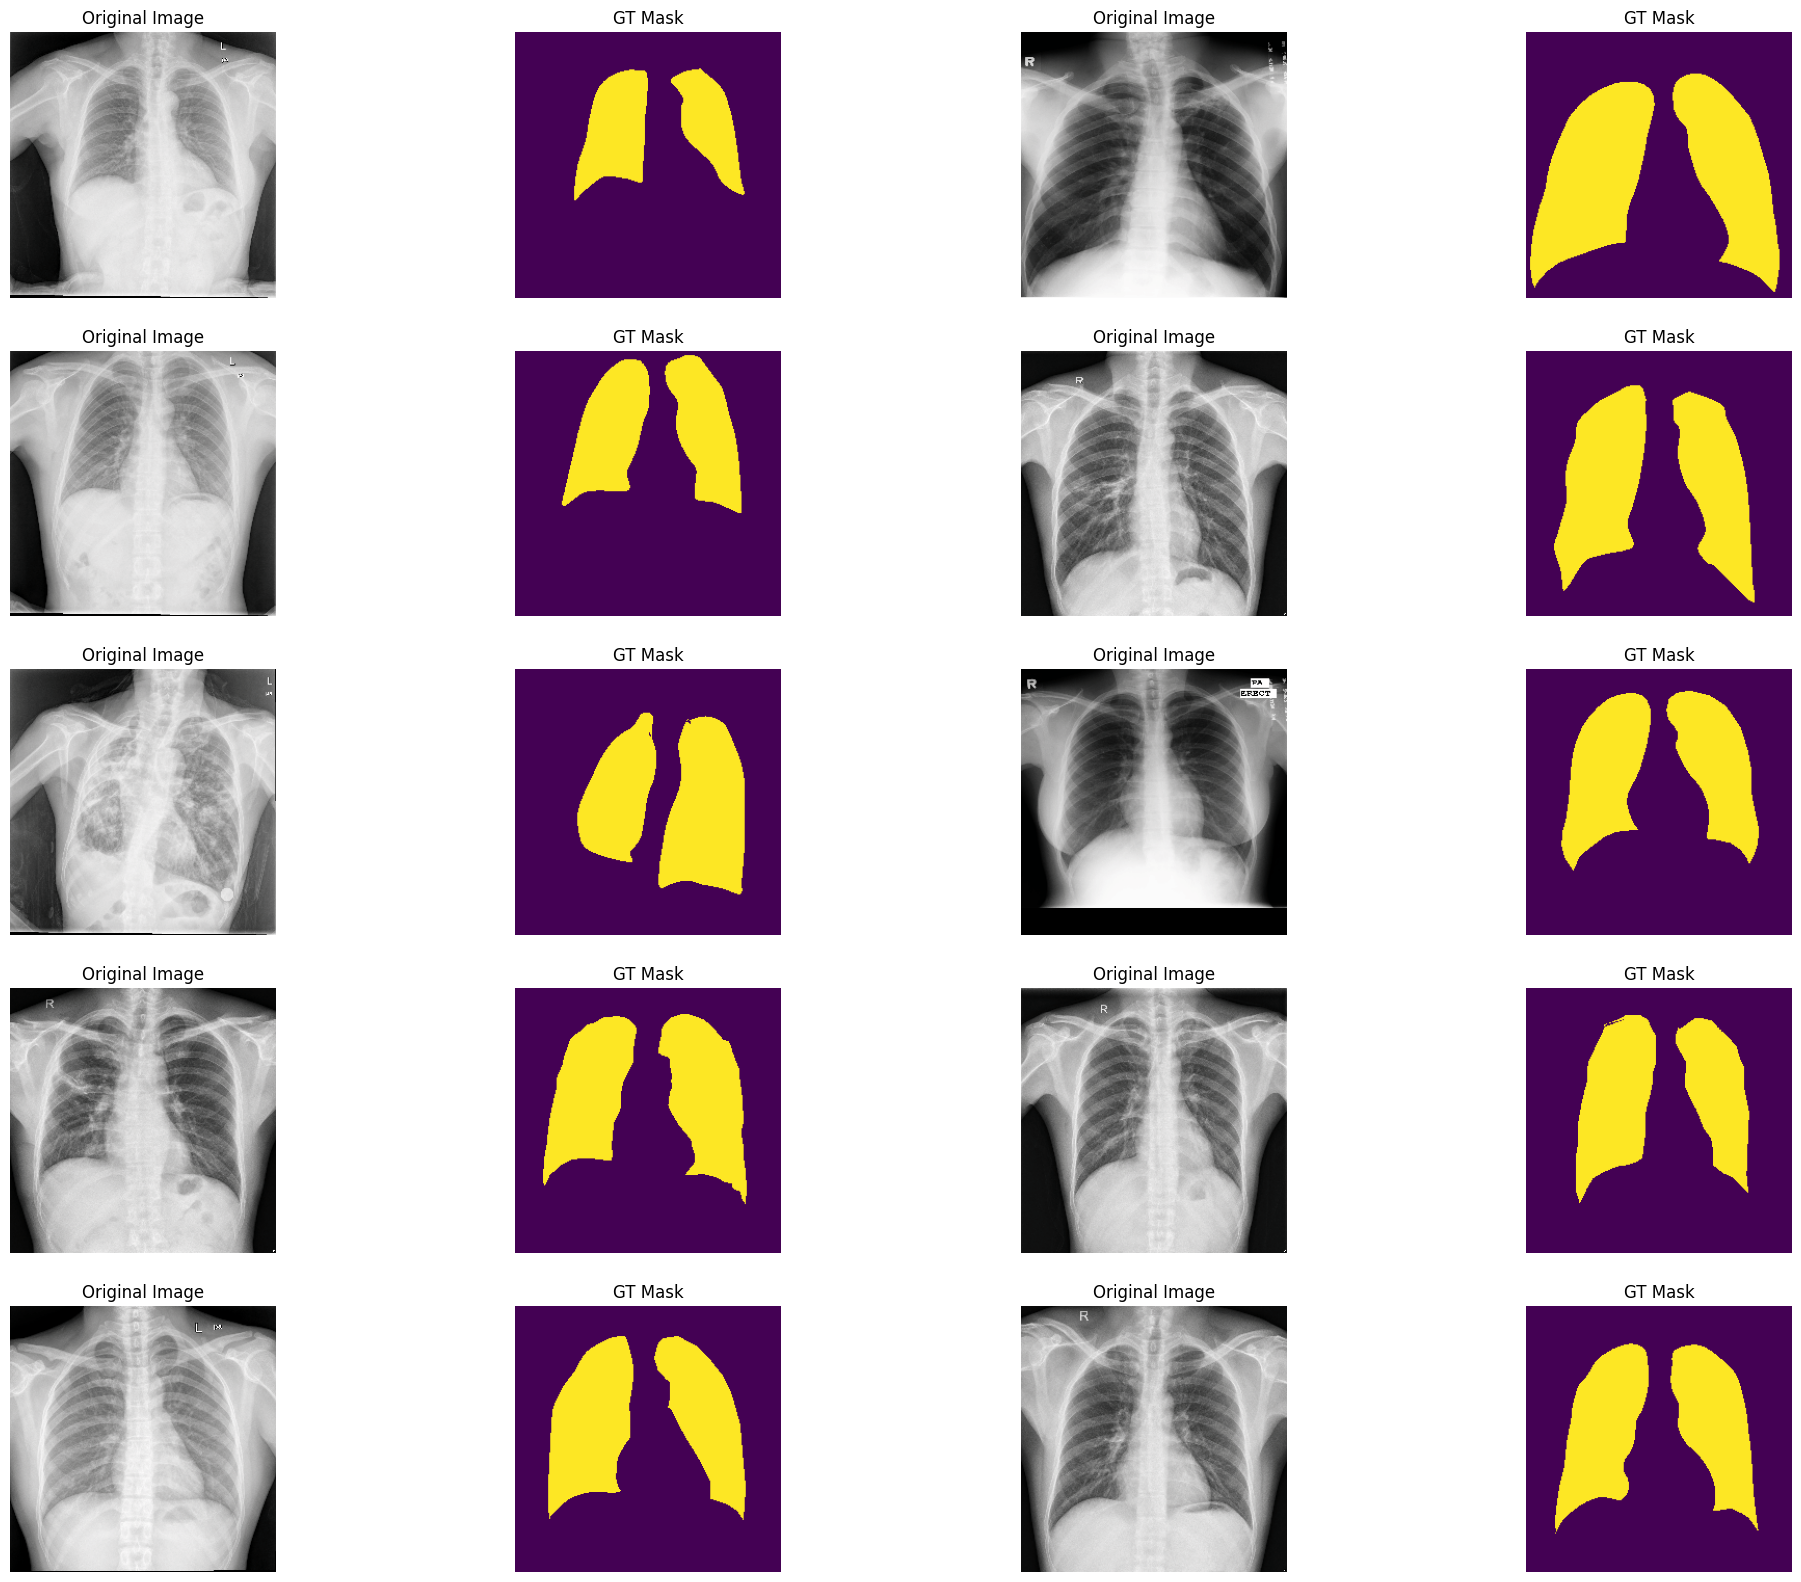

In [ ]:
import random
from torchvision import transforms as tfs

def tn_2_np(t):
    invTrans = tfs.Compose([ tfs.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                tfs.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ]) ])

    rgb = True if len(t) == 3 else False

    return (invTrans(t) * 255).detach().cpu().permute(1,2,0).numpy().astype(np.uint8) if rgb else (t*255).detach().cpu().numpy().astype(np.uint8)

def plot(rows, cols, count, im, gt = None, title = "Original Image"):

    plt.subplot(rows, cols, count)
    plt.imshow(tn_2_np(im.squeeze(0).float())) if gt else plt.imshow(tn_2_np(im.squeeze(0)))
    plt.axis("off"); plt.title(title)

    return count + 1

def visualize(ds, n_ims):

    plt.figure(figsize = (25, 20))
    rows = n_ims // 4; cols = n_ims // rows
    count = 1
    indices = [random.randint(0, len(ds) - 1) for _ in range(n_ims)]

    for idx, index in enumerate(indices):

        if count == n_ims + 1: break
        im, gt = ds[index]

        # First Plot
        count = plot(rows, cols, count, im = im)

        # Second Plot
        count = plot(rows, cols, count, im = gt, gt = True, title = "GT Mask")

visualize(tr_dl.dataset, n_ims = 20)

In [ ]:
!pip install segmentation_models_pytorch
import segmentation_models_pytorch as smp, time
from tqdm import tqdm
from torch.nn import functional as F

model = smp.DeepLabV3Plus(classes = n_cls)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = 3e-4)

class Metrics():

    def __init__(self, pred, gt, loss_fn, eps = 1e-10, n_cls = 2):

        self.pred, self.gt = torch.argmax(F.softmax(pred, dim=1), dim = 1), gt # (batch, width, height)
        self.loss_fn, self.eps, self.n_cls, self.pred_ = loss_fn, eps, n_cls, pred

    def to_contiguous(self, inp): return inp.contiguous().view(-1)

    def PA(self):

        with torch.no_grad():
            match = torch.eq(self.pred, self.gt).int()

        return float(match.sum()) / float(match.numel())

    def mIoU(self):

        with torch.no_grad():
            # self.gt = torch.argmax(self.gt, dim = 1)

            pred, gt = self.to_contiguous(self.pred), self.to_contiguous(self.gt)

            iou_per_class = []

            for c in range(self.n_cls):

                match_pred = pred == c
                match_gt   = gt == c

                if match_gt.long().sum().item() == 0: iou_per_class.append(np.nan)

                else:

                    intersect = torch.logical_and(match_pred, match_gt).sum().float().item()
                    union = torch.logical_or(match_pred, match_gt).sum().float().item()

                    iou = (intersect + self.eps) / (union + self.eps)
                    iou_per_class.append(iou)

            return np.nanmean(iou_per_class)

    def loss(self): return self.loss_fn(self.pred_, self.gt.long())

def tic_toc(start_time = None): return time.time() if start_time == None else time.time() - start_time

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 289MB/s]


In [ ]:
save_prefix = ""
def train(model, tr_dl, val_dl, loss_fn, opt, device, epochs, save_prefix, threshold = 0.01, save_path = "saved_models"):

    tr_loss, tr_pa, tr_iou = [], [], []
    val_loss, val_pa, val_iou = [], [], []
    tr_len, val_len = len(tr_dl), len(val_dl)
    best_loss, decrease, not_improve, early_stop_threshold = np.inf, 1, 0, 5
    os.makedirs(save_path, exist_ok = True)

    model.to(device)
    train_start = tic_toc()
    print("Start training process...")

    for epoch in range(1, epochs + 1):
        tic = tic_toc()
        tr_loss_, tr_iou_, tr_pa_ = 0, 0, 0

        model.train()
        print(f"Epoch {epoch} train process is started...")
        for idx, batch in enumerate(tqdm(tr_dl)):

            ims, gts = batch
            ims, gts = ims.to(device), gts.to(device)

            preds = model(ims)

            met = Metrics(preds, gts, loss_fn, n_cls = n_cls)
            loss_ = met.loss()

            tr_iou_ += met.mIoU()

            tr_pa_ += met.PA()
            tr_loss_ += loss_.item()

            loss_.backward()
            opt.step()
            opt.zero_grad()

        print(f"Epoch {epoch} validation process is started...")
        model.eval()
        val_loss_, val_iou_, val_pa_ = 0, 0, 0

        with torch.no_grad():
            for idx, batch in enumerate(tqdm(val_dl)):

                ims, gts = batch
                ims, gts = ims.to(device), gts.to(device)

                preds = model(ims)

                met = Metrics(preds, gts, loss_fn, n_cls = n_cls)

                val_loss_ += met.loss().item()
                val_iou_ += met.mIoU()
                val_pa_ += met.PA()


        print(f"Epoch {epoch} train process is completed.")

        tr_loss_ /= tr_len
        tr_iou_ /= tr_len
        tr_pa_ /= tr_len

        val_loss_ /= val_len
        val_iou_ /=  val_len
        val_pa_ /=   val_len

        print("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
        print(f"\nEpoch {epoch} train process results: \n")
        print(f"Train Time         -> {tic_toc(tic):.3f} secs")
        print(f"Train Loss         -> {tr_loss_:.3f}")
        print(f"Train PA           -> {tr_pa_:.3f}")
        print(f"Train IoU          -> {tr_iou_:.3f}")
        print(f"Validation Loss    -> {val_loss_:.3f}")
        print(f"Validation PA      -> {val_pa_:.3f}")
        print(f"Validation IoU     -> {val_iou_:.3f}\n")

        tr_loss.append(tr_loss_)
        tr_iou.append(tr_iou_)
        tr_pa.append(tr_pa_)

        val_loss.append(val_loss_)
        val_iou.append(val_iou_)
        val_pa.append(val_pa_)

        if (val_loss_ + threshold) < best_loss:
            print(f"Loss decreased from {best_loss:.3f} to {val_loss_:.3f}!")
            best_loss = val_loss_
            decrease += 1
            print("Saving the model with the best loss value...")
            torch.save(model, f"{save_path}/{save_prefix}_best_model.pt")

        else:
            not_improve += 1
            best_loss = val_loss_
            print(f"Loss did not decrease for {not_improve} epoch(s)!")
            if not_improve == early_stop_threshold:
                print(f"Stopping training process becuase loss value did not decrease for {early_stop_threshold} epochs!")
                break
        print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")

    print(f"Train process is completed in {(tic_toc(train_start)) / 60:.3f} minutes.")

    return {"tr_loss": tr_loss, "tr_iou": tr_iou, "tr_pa": tr_pa,
            "val_loss": val_loss, "val_iou": val_iou, "val_pa" : val_pa}

device = "cuda" if torch.cuda.is_available() else "cpu"

history = train(model = model, tr_dl = tr_dl, val_dl = val_dl,
                 loss_fn = loss_fn, opt = optimizer, device = device,
                 epochs = 20, save_prefix = save_prefix)

Start training process...
Epoch 1 train process is started...


100%|██████████| 40/40 [11:47<00:00, 17.70s/it]


Epoch 1 validation process is started...


100%|██████████| 3/3 [00:39<00:00, 13.06s/it]


Epoch 1 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 1 train process results: 

Train Time         -> 747.073 secs
Train Loss         -> 0.190
Train PA           -> 0.931
Train IoU          -> 0.862
Validation Loss    -> 0.103
Validation PA      -> 0.969
Validation IoU     -> 0.924

Loss decreased from inf to 0.103!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 2 train process is started...


100%|██████████| 40/40 [12:19<00:00, 18.48s/it]


Epoch 2 validation process is started...


100%|██████████| 3/3 [00:37<00:00, 12.51s/it]


Epoch 2 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 2 train process results: 

Train Time         -> 776.606 secs
Train Loss         -> 0.072
Train PA           -> 0.977
Train IoU          -> 0.941
Validation Loss    -> 0.078
Validation PA      -> 0.973
Validation IoU     -> 0.932

Loss decreased from 0.103 to 0.078!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 3 train process is started...


100%|██████████| 40/40 [12:28<00:00, 18.70s/it]


Epoch 3 validation process is started...


100%|██████████| 3/3 [00:37<00:00, 12.37s/it]


Epoch 3 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 3 train process results: 

Train Time         -> 785.279 secs
Train Loss         -> 0.060
Train PA           -> 0.979
Train IoU          -> 0.947
Validation Loss    -> 0.071
Validation PA      -> 0.975
Validation IoU     -> 0.938

Loss did not decrease for 1 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 4 train process is started...


100%|██████████| 40/40 [12:26<00:00, 18.66s/it]


Epoch 4 validation process is started...


100%|██████████| 3/3 [00:38<00:00, 12.90s/it]


Epoch 4 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 4 train process results: 

Train Time         -> 785.115 secs
Train Loss         -> 0.053
Train PA           -> 0.981
Train IoU          -> 0.951
Validation Loss    -> 0.066
Validation PA      -> 0.976
Validation IoU     -> 0.941

Loss did not decrease for 2 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 5 train process is started...


100%|██████████| 40/40 [12:24<00:00, 18.61s/it]


Epoch 5 validation process is started...


100%|██████████| 3/3 [00:37<00:00, 12.42s/it]


Epoch 5 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 5 train process results: 

Train Time         -> 781.664 secs
Train Loss         -> 0.047
Train PA           -> 0.983
Train IoU          -> 0.955
Validation Loss    -> 0.067
Validation PA      -> 0.977
Validation IoU     -> 0.942

Loss did not decrease for 3 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 6 train process is started...


100%|██████████| 40/40 [12:15<00:00, 18.38s/it]


Epoch 6 validation process is started...


100%|██████████| 3/3 [00:36<00:00, 12.23s/it]


Epoch 6 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 6 train process results: 

Train Time         -> 771.768 secs
Train Loss         -> 0.043
Train PA           -> 0.984
Train IoU          -> 0.958
Validation Loss    -> 0.062
Validation PA      -> 0.978
Validation IoU     -> 0.945

Loss did not decrease for 4 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 7 train process is started...


100%|██████████| 40/40 [12:35<00:00, 18.89s/it]


Epoch 7 validation process is started...


100%|██████████| 3/3 [00:37<00:00, 12.63s/it]

Epoch 7 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 7 train process results: 

Train Time         -> 793.561 secs
Train Loss         -> 0.041
Train PA           -> 0.984
Train IoU          -> 0.960
Validation Loss    -> 0.066
Validation PA      -> 0.977
Validation IoU     -> 0.942

Loss did not decrease for 5 epoch(s)!
Stopping training process becuase loss value did not decrease for 5 epochs!
Train process is completed in 90.690 minutes.


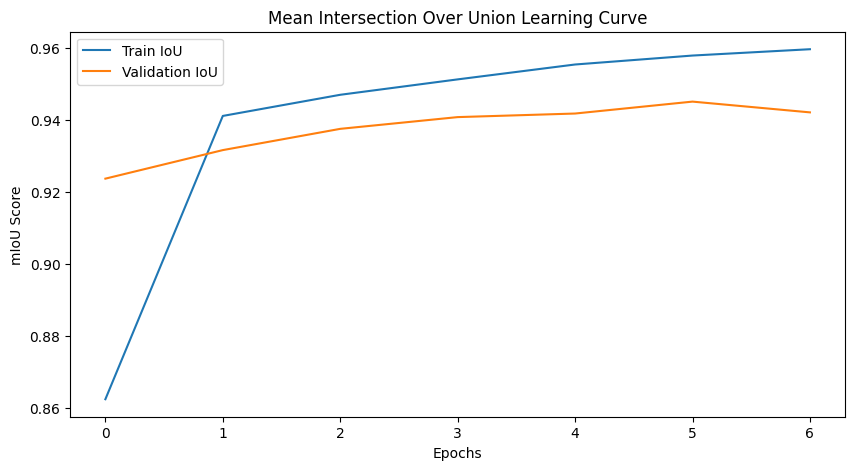

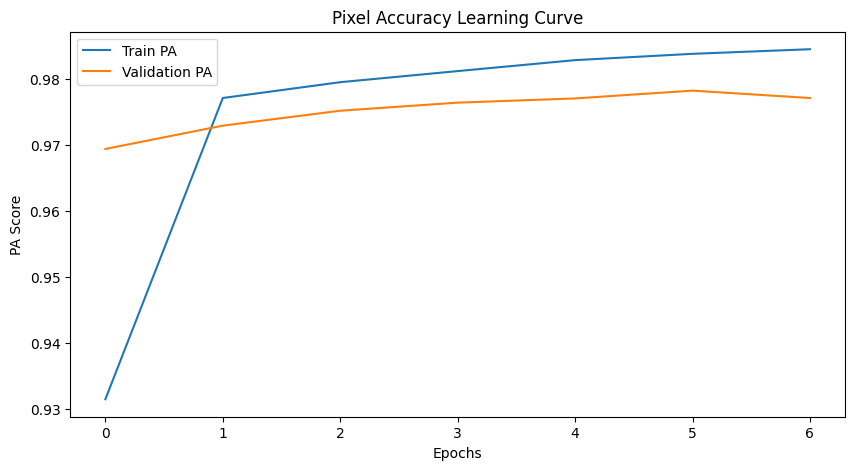

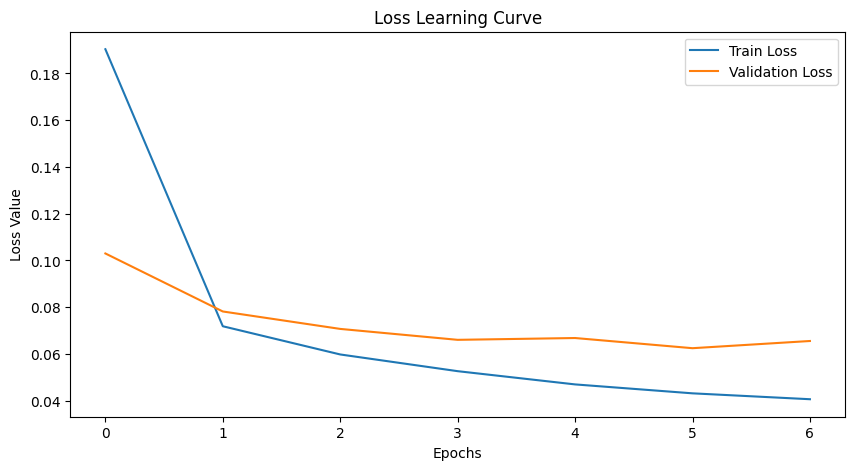

In [ ]:
class Plot():

    def __init__(self, res):

        self.res = res

        self.visualize(metric1 = "tr_iou", metric2 = "val_iou", label1 = "Train IoU",
                  label2 = "Validation IoU", title = "Mean Intersection Over Union Learning Curve", ylabel = "mIoU Score")

        self.visualize(metric1 = "tr_pa", metric2 = "val_pa", label1 = "Train PA",
                  label2 = "Validation PA", title = "Pixel Accuracy Learning Curve", ylabel = "PA Score")

        self.visualize(metric1 = "tr_loss", metric2 = "val_loss", label1 = "Train Loss",
                  label2 = "Validation Loss", title = "Loss Learning Curve", ylabel = "Loss Value")


    def plot(self, metric, label): plt.plot(self.res[metric], label = label)

    def decorate(self, ylabel, title): plt.title(title); plt.xlabel("Epochs"); plt.ylabel(ylabel); plt.legend(); plt.show()

    def visualize(self, metric1, metric2, label1, label2, title, ylabel):

        plt.figure(figsize=(10, 5))
        self.plot(metric1, label1); self.plot(metric2, label2)
        self.decorate(ylabel, title)

Plot(history)

<ipython-input-14-73c9f2552593>:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(f"saved_models/{save_prefix}_best_model.pt")


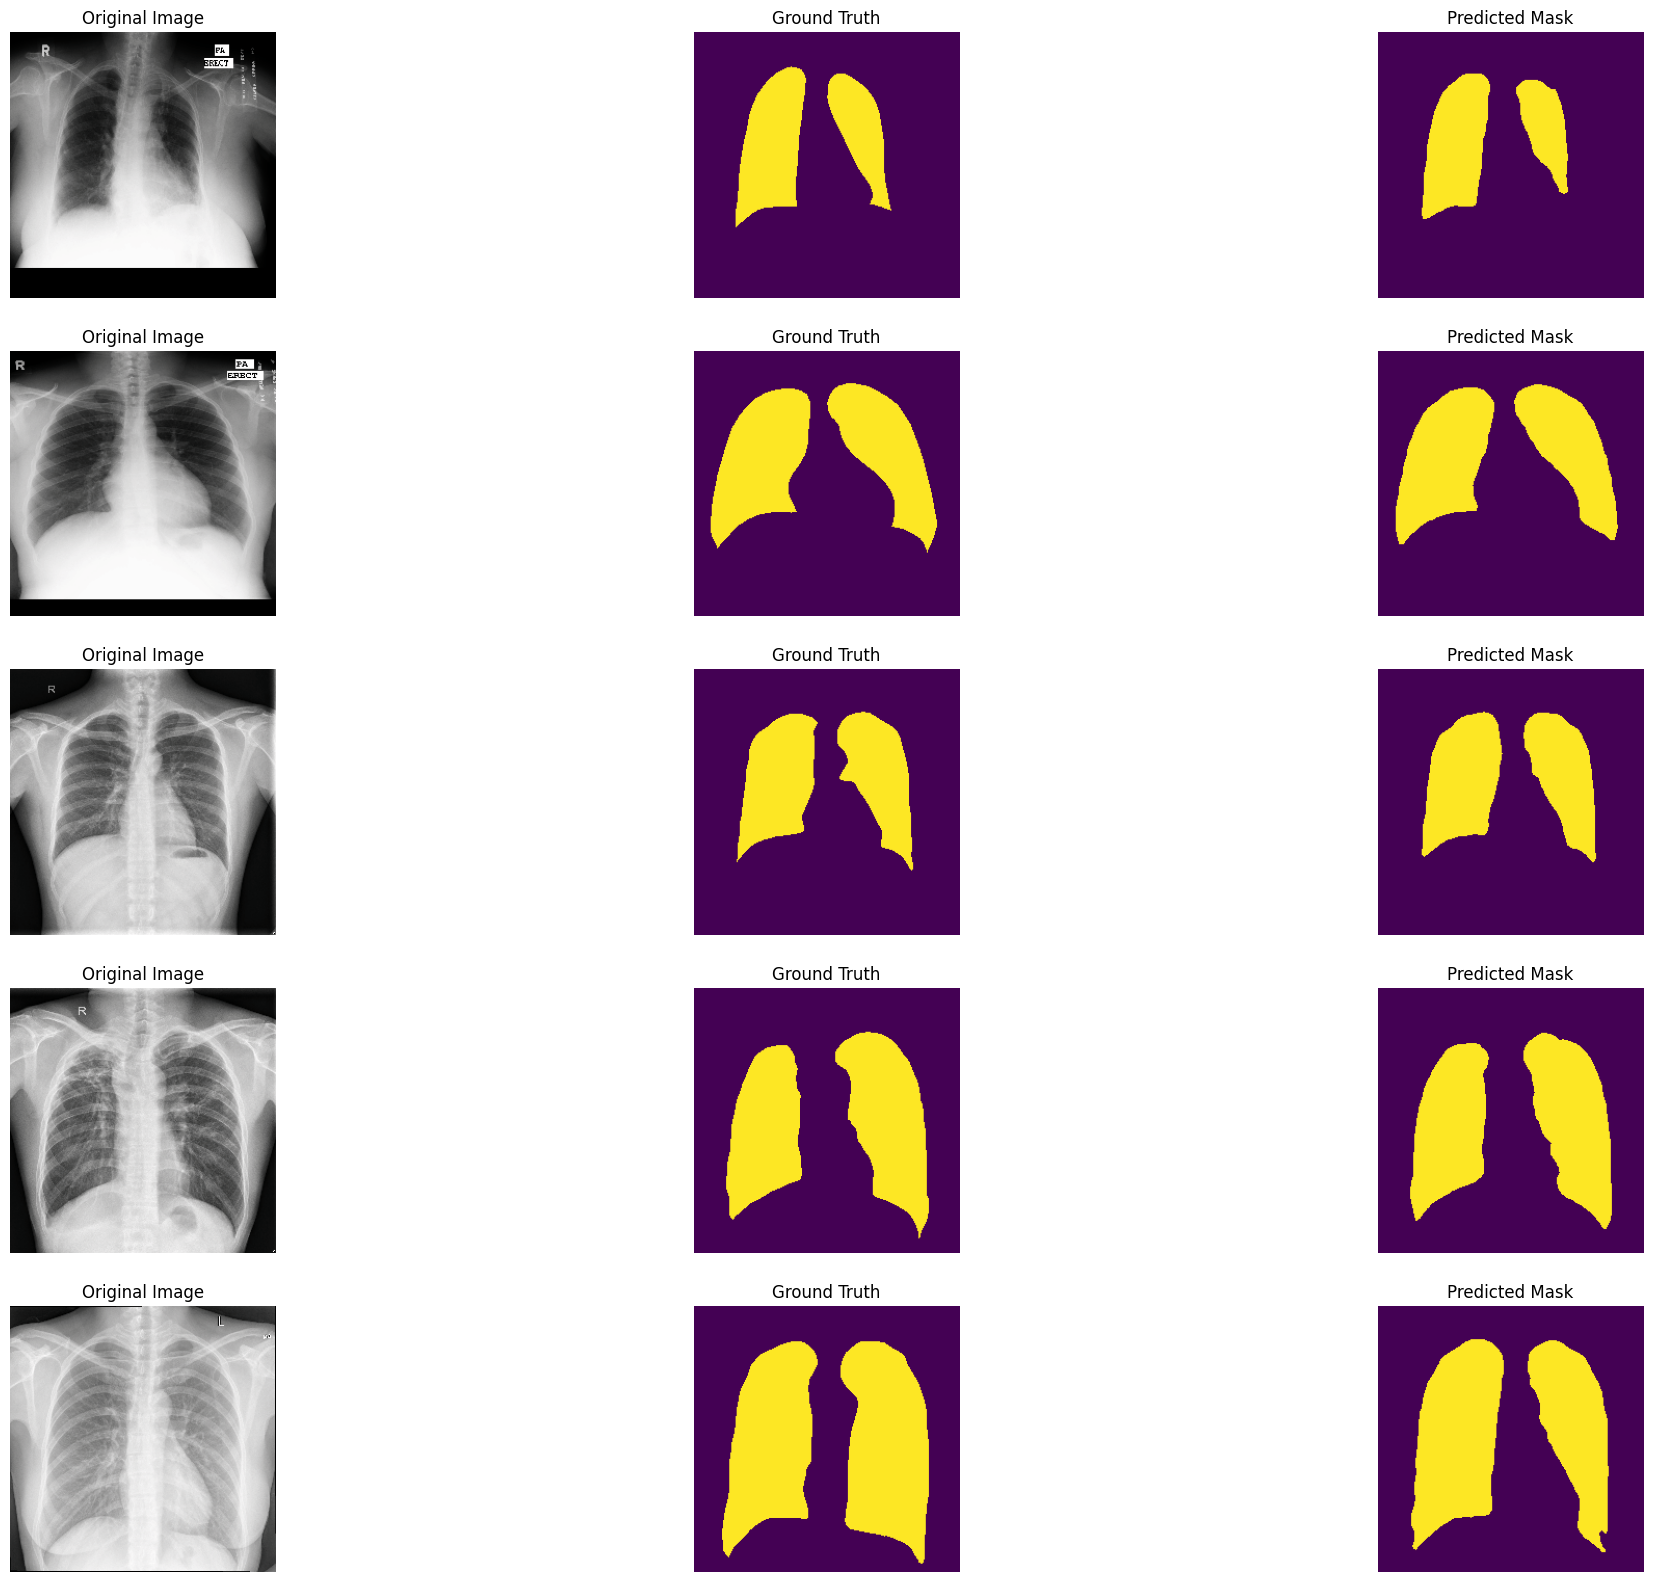

In [ ]:
def inference(dl, model, device, n_ims = 15):

    cols = n_ims // 3; rows = n_ims // cols

    count = 1
    ims, gts, preds = [], [], []
    for idx, data in enumerate(dl):
        im, gt = data

        # Get predicted mask
        with torch.no_grad(): pred = torch.argmax(model(im.to(device)), dim = 1)
        ims.append(im); gts.append(gt); preds.append(pred)

    plt.figure(figsize = (25, 20))
    for idx, (im, gt, pred) in enumerate(zip(ims, gts, preds)):
        if idx == cols: break

        # First plot
        count = plot(cols, rows, count, im)

        # Second plot
        count = plot(cols, rows, count, im = gt.squeeze(0), gt = True, title = "Ground Truth")

        # Third plot
        count = plot(cols, rows, count, im = pred, title = "Predicted Mask")

model = torch.load(f"saved_models/{save_prefix}_best_model.pt")
inference(test_dl, model = model, device = device)

In [ ]:
!pip install torchsummary

In [ ]:
print(model)

DeepLabV3Plus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tr

In [ ]:
from torchsummary import summary
import torch
summary(model, input_size=(3, 224, 224))  # Example input size


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [ ]:
!pip install torchviz


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 1.6 MB/s eta 0:00:00


In [ ]:
import torch
from torchviz import make_dot

# Dummy input tensor matching the input size expected by the model
dummy_input = torch.randn(1, 3, 512, 512).to("cuda" if torch.cuda.is_available() else "cpu")

# Forward pass to generate the computation graph
output = model(dummy_input)

# Visualize the graph
make_dot(output, params=dict(model.named_parameters())).render("DeepLabV3Plus", format="png")


'DeepLabV3Plus.png'

In [ ]:
from PIL import Image
Image.open("DeepLabV3Plus.png")
